# 自举聚合与随机森林

## np.random.randint()
- https://blog.csdn.net/u011851421/article/details/83544853
- 返回一个随机整型数

## np.bincount()
- https://blog.csdn.net/m0_37885275/article/details/92992078

In [17]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split

# 创建随机数据集
X, y = make_classification(
    n_samples=1000,  # 数据集大小
    n_features=16,  # 特征数，及数据维度
    n_informative=5,  # 有效特征数
    n_redundant=2,  # 冗余特征数
    n_classes=2,  # 类别数
    flip_y=0.1,  # 类别随机的样本个数，该值越大，分类越困难
    random_state=0  # 随机种子
)
print(X.shape)

(1000, 16)


In [18]:
class RandomForest:
    def __init__(self, n_trees=10, max_features='sqrt'):
        # max_feature是DTC的参数，表示节点分裂时随机采样的特征个数
        # sqrt代表取全部特征的平方根，None：取全部特征，log2：取全部特征的对数
        self.n_trees = n_trees
        self.oob_score = 0
        self.trees = [DTC(max_features=max_features) for _ in range(n_trees)]

    # 用X和y训练模型
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = np.unique(y).shape[0]
        # 集成模型的预测，累加单个模型预测的分类概率，再取较大值最为最终分类
        ensemble = np.zeros((n_samples, self.n_classes))
        for tree in self.trees:
            # 自举采样，该采样允许重复
            idx = np.random.randint(0, n_samples, n_samples)
            # 没有被采到的样本
            unsampled_mask = np.bincount(idx, minlength=n_samples) == 0
            unsampled_idx = np.arange(n_samples)[unsampled_mask]
            # 训练当前决策树
            tree.fit(X[idx], y[idx])
            # 累加决策树对OOB样本的预测
            ensemble[unsampled_idx] += tree.predict_proba(X[unsampled_idx])
        # 计算OOB分数，由于是分类问题，我们用准确率来衡量
        self.oob_score = np.mean(y == np.argmax(ensemble, axis=1))

    # 预测类别
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)
    
    def predict_proba(self, X):
        # 取所有决策树预测概率的平均
        ensemble = np.mean([tree.predict_proba(X) for tree in self.trees],
                           axis = 0)
        return ensemble
    
    # 计算准确率
    def score(self, X, y):
        return np.mean(y == self.predict(X))

In [19]:
# 算法测试与可视化
num_trees = np.arange(1, 101, 5)
np.random.seed(0)
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

100%|██████████| 20/20 [00:05<00:00,  3.65it/s, n_tree=96, train_score=1, oob_score=0.897]    


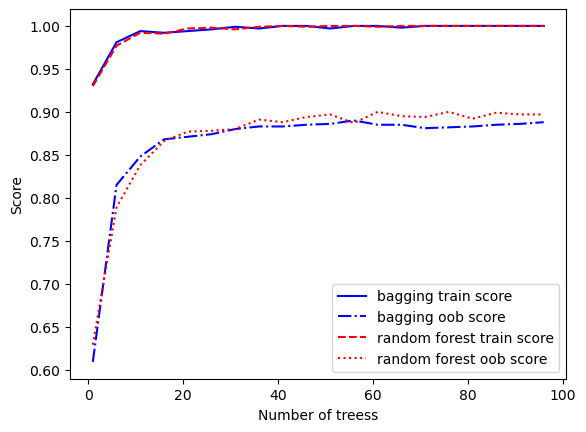

In [20]:
# bagging算法
oob_score = []
train_score = []
with tqdm(num_trees) as pbar:
    for n_tree in pbar:
        rf = RandomForest(n_trees=n_tree, max_features=None)
        rf.fit(X, y)
        train_score.append(rf.score(X, y))
        oob_score.append(rf.oob_score)
        pbar.set_postfix({  # 设置进度条显示信息
            'n_tree': n_tree,
            'train_score': train_score[-1],
            'oob_score': oob_score[-1]
        })
plt.plot(num_trees, train_score, color='blue', label='bagging train score')
plt.plot(num_trees, oob_score, color='blue', ls='-.', label='bagging oob score')

# 随机森林
oob_score = []
train_score = []
with tqdm(num_trees) as pbar:
    for n_tree in pbar:
        rf = RandomForest(n_trees=n_tree, max_features='sqrt')
        rf.fit(X, y)
        train_score.append(rf.score(X, y))
        oob_score.append(rf.oob_score)
        pbar.set_postfix({
            'n_tree': n_tree,
            'train_score': train_score[-1],
            'oob_score': oob_score[-1]
        })
plt.plot(num_trees, train_score, color='red', ls='--',
         label='random forest train score')
plt.plot(num_trees, oob_score, color='red', ls=':',
         label='random forest oob score')

plt.ylabel('Score')
plt.xlabel('Number of treess')
plt.legend()
plt.show()

In [21]:
# sklearn中的bagging算法和随机森林算法
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
bc = BaggingClassifier(n_estimators=100, oob_score=True, random_state=0)
bc.fit(X, y)
print('bagging:', bc.oob_score_)

rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt',
                             oob_score=True, random_state=0)
print('随机森林：', rfc.oob_score)

bagging: 0.885
随机森林： True
